In [98]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [99]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [101]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [102]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [103]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [104]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [105]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [106]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [108]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


<Figure size 1000x600 with 0 Axes>

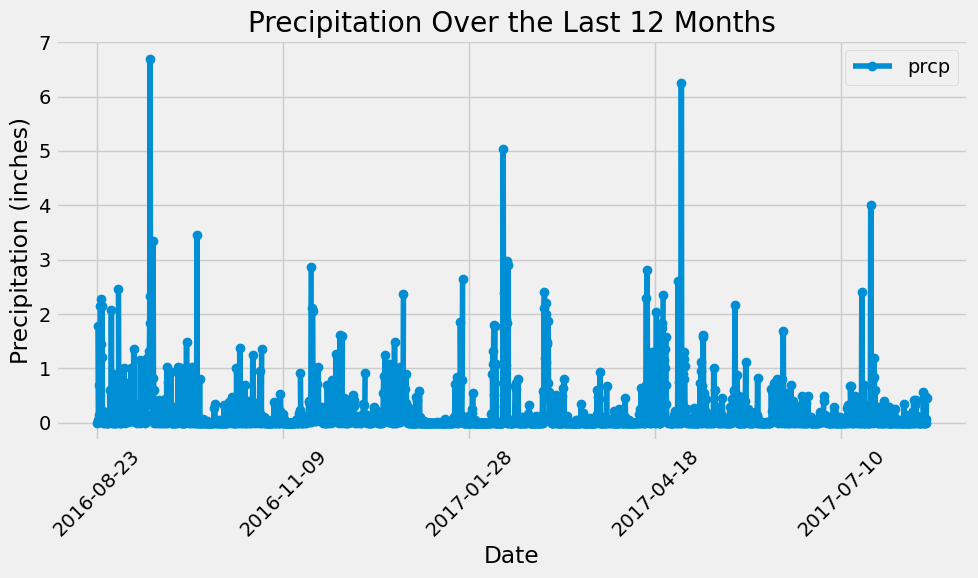

In [109]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
precipitation_df.plot(x='date', y='prcp', marker='o', linestyle='-', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [110]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df.describe()
print(summary_stats)

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [112]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [113]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                   .group_by(Measurement.station)
                   .order_by(func.count(Measurement.station).desc())
                   .all())

# List the stations and their counts in descending order.
print("Most active stations (Station ID, Number of Observations):")
for station, count in active_stations:
    print(f"{station}: {count}")


Most active stations (Station ID, Number of Observations):
USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [114]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0] 

temperature_stats = (session.query(func.min(Measurement.tobs), 
                                   func.max(Measurement.tobs), 
                                   func.avg(Measurement.tobs))
                     .filter(Measurement.station == most_active_station_id)
                     .all())

print(f"Temperature stats for the most active station ({most_active_station_id}):")
print(f"Lowest temperature: {temperature_stats[0][0]}°F")
print(f"Highest temperature: {temperature_stats[0][1]}°F")
print(f"Average temperature: {temperature_stats[0][2]:.2f}°F")

Temperature stats for the most active station (USC00519281):
Lowest temperature: 54.0°F
Highest temperature: 85.0°F
Average temperature: 71.66°F


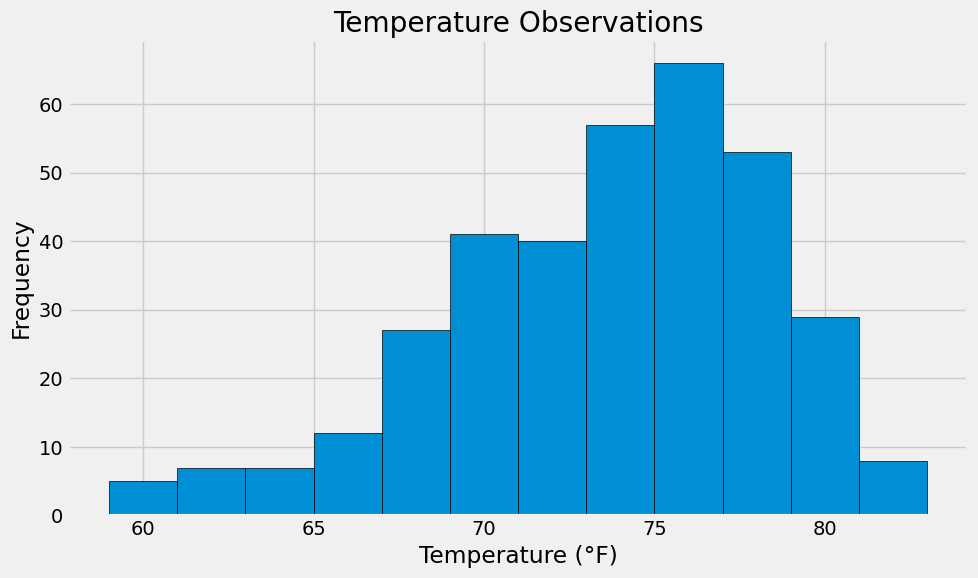

In [115]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = (session.query(Measurement.tobs)
             .filter(Measurement.station == most_active_station_id)
             .filter(Measurement.date >= one_year_ago)
             .all())
tobs_list = [temp[0] for temp in tobs_data]

plt.figure(figsize=(10, 6)) 
plt.hist(tobs_list, bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations')
plt.tight_layout()
plt.show()

# Close Session

In [117]:
# Close Session
session.close()